In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt

from mne.time_frequency import psd_welch
from mne.datasets.sleep_physionet.age import fetch_data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dense, BatchNormalization, LSTM, Flatten, TimeDistributed, ELU, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import tensorflow.keras.backend as K


2021-09-23 17:14:41.404237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Loading data using MNE for two subjects.

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/sahild/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-2a0a3ecbe38d>:16: RuntimeWarning: The unit for channel(s) Resp oro-nasal has changed from V to NA.
  raw_train.set_channel_types(mapping)


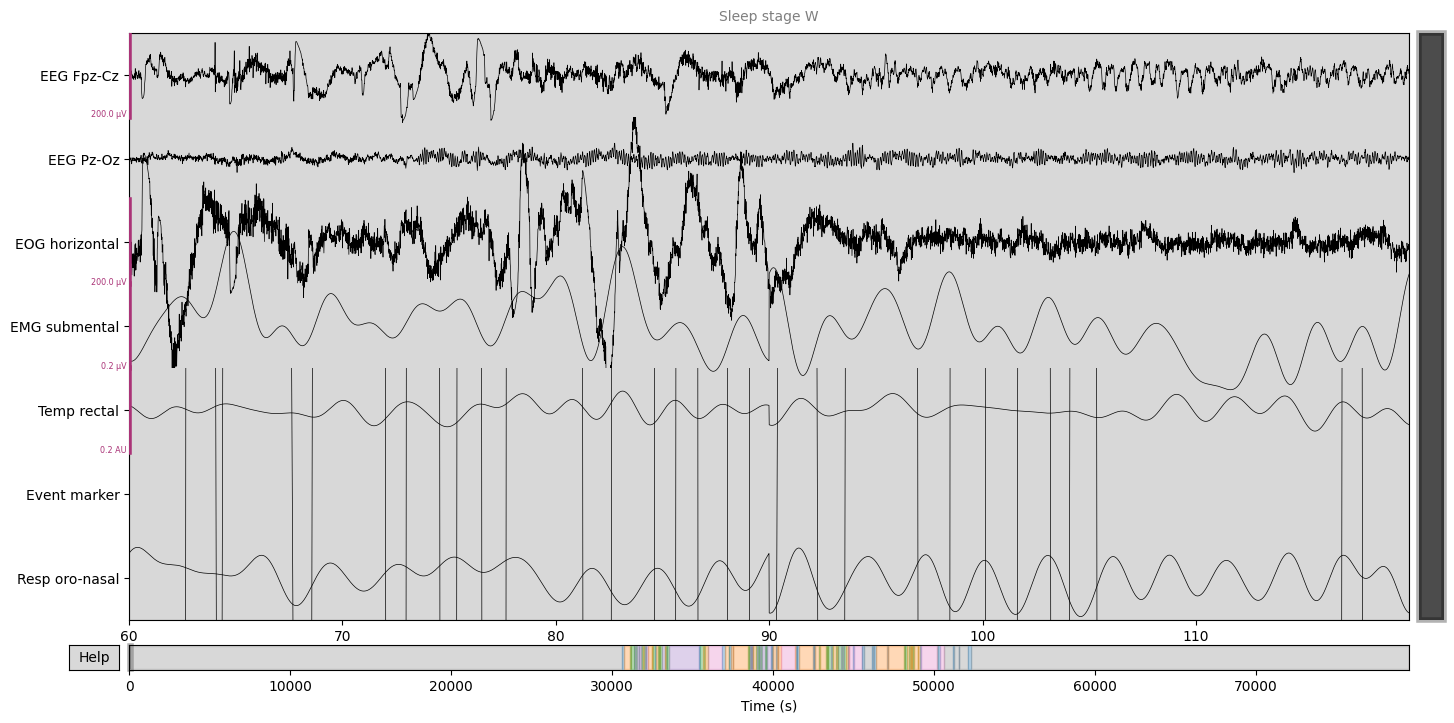

Channels marked as bad: none


In [4]:
# (Note: these are not the real names of the participants)
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'resp',
           'EMG submental': 'emg',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train = mne.io.read_raw_edf(alice_files[0])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60, scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1))

The dataset contains 8 labels each for a different sleep stage. However, in this analysis we will work only with 5 stages: Wake (W), Stage 1, Stage 2, Stage 3/4, and REM sleep (R). In order to do this, we use the "event_id" parameter in mne.events_from_annotations() to select events of interest.



In [5]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,sfreq=raw_train.info['sfreq'],first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


Extract trials from raw data based on the events in the annotations created above.

In [6]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 188>


Applying similar steps to the test data from Bob (Note: these are not the real names of the participants).

In [7]:
raw_test = mne.io.read_raw_edf(bob_files[0])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60, annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
raw_test.set_channel_types(mapping)
events_test, _ = mne.events_from_annotations(raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /home/sahild/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 157>


<ipython-input-7-9e623a84efcc>:5: RuntimeWarning: The unit for channel(s) Resp oro-nasal has changed from V to NA.
  raw_test.set_channel_types(mapping)


In [8]:
trainX, testX = epochs_train.get_data(), epochs_test.get_data()

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped


In [9]:
print("The number of training trials are:",trainX.shape)
print("The number of testing trials are:",testX.shape)
trainY, testY = epochs_train.events[:,2], epochs_test.events[:,2]

The number of training trials are: (841, 7, 3000)
The number of testing trials are: (1103, 7, 3000)


In [11]:
# training data
unique, counts = np.unique(trainY, return_counts = True)
dict(zip(unique, counts))

{1: 188, 2: 58, 3: 250, 4: 220, 5: 125}

In [12]:
# for test data
unique1, counts1 = np.unique(testY, return_counts = True)
dict(zip(unique1, counts1))

{1: 157, 2: 109, 3: 562, 4: 105, 5: 170}

In [13]:

def create_datasets(train, trainy):
    data1, data2, data3, data4, data5 =  list(), list(), list(), list(), list()
    for i in range(len(train)):
        if trainy[i] == 1:
            data1.append(train[i])
        elif trainy[i] == 2:
            data2.append(train[i])
        elif trainy[i] == 3:
            data3.append(train[i])
        elif trainy[i] ==4:
            data4.append(train[i])
        else:
            data5.append(train[i])
    return data1, data2, data3, data4, data5
            
def combine_datasets(trainX, testX, trainy, testy): 
    # create trainsets
    train1, train2, train3, train4, train5 = create_datasets(trainX, trainy) 
    # create testsets
    test1, test2, test3, test4, test5 = create_datasets(testX, testy)
    t1 = np.concatenate([train1, test1], axis=0)
    t2 = np.concatenate([train2, test2], axis=0)
    t3 = np.concatenate([train3, test3], axis=0)
    t4 = np.concatenate([train4, test4], axis=0)
    t5 = np.concatenate([train5, test5], axis=0)
    a, b, c, d, e = t1.shape[0], t2.shape[0], t3.shape[0], t4.shape[0], t5.shape[0]
    t = np.concatenate([t1,t2,t3,t4,t5],axis=0)
    return t, [a,b,c,d,e]

data, size = combine_datasets(trainX, testX, trainY, testY)
print(data.shape)

(1944, 7, 3000)


In [23]:
from sklearn.model_selection import train_test_split
a,b,c,d,e = size
train_y = np.zeros((data.shape[0]))
train_y[0:a] = 1
train_y[a:a+b] = 2
train_y[a+b: a+b+c] = 3
train_y[a+b+c:a+b+c+d] = 4

train_y = to_categorical(train_y)
print(train_y.shape)

trainX, testX, trainy, testy = train_test_split(data, train_y, test_size = 0.10)

(1944, 5)


In [24]:
# creates feature of 100x6x64
def temporal_slider(trainX): 
    t = list()
    c = np.arange(0,3000,500) 
    for i in c: 
        t.append(trainX[:,i:i+50,:][:,np.newaxis,:,:])
    t = np.concatenate(t,axis=1)
    return t

# this performs scalling the data on train signals
# this performs scaling the test data across channels
def scaled(trainX, testX):
    sc = StandardScaler()
    scaled_data, scaled_test = list(), list()
    trainX, testX = trainX.swapaxes(2,1), testX.swapaxes(2,1)
    # take the time series across each channel
    for ele in range(trainX.shape[2]): 
      # take the data from trian and fit
        scaled_channel = sc.fit_transform(trainX[:,:,ele])
        scaled_channel = scaled_channel[:,:,np.newaxis]
        # trainsform the test data
        scaled_channels = sc.transform(testX[:,:,ele])
        scaled_channels = scaled_channels[:,:,np.newaxis]
        # append the train and test data list
        scaled_data.append(scaled_channel)
        scaled_test.append(scaled_channels)
    scaled_data = np.concatenate(scaled_data,axis=2) 
    scaled_test = np.concatenate(scaled_test,axis=2) 
    return scaled_data, scaled_test


# scale the data
trainX, testX = scaled(trainX, testX)
# convert to appropriate shape 
trainX, testX = temporal_slider(trainX), temporal_slider(testX)
print(trainX.shape)

(1749, 6, 50, 7)


In [31]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, Conv1D, LSTM, Dense, Flatten, BatchNormalization, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.layers import Input, Reshape, Activation, RepeatVector, Multiply, Lambda, Permute
from tensorflow.keras.models import Model



def cnn1d_timedistributed(trainX):
    _,a,b,c = trainX.shape
    # network-1
    inputs1 = Input(shape=(a,b,c))
    # Block-1
    out = TimeDistributed(Conv1D(64,(3), strides = (2), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_uniform'))(inputs1)
    out = TimeDistributed(AveragePooling1D(pool_size = 2, strides = 2))(out)
    out = TimeDistributed(BatchNormalization(center = True, scale = True))(out)
    # Block-2
    out = TimeDistributed(Conv1D(128,(3), strides = (2), activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform'))(out)
    out = TimeDistributed(AveragePooling1D(pool_size = 2, strides = 2))(out)
    out = TimeDistributed(BatchNormalization(center = True, scale = True))(out)
    # Block-2
    out = TimeDistributed(Conv1D(128,(3), strides = (2), activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform'))(out)
    out = TimeDistributed(AveragePooling1D(pool_size = 2, strides = 2))(out)
    out = TimeDistributed(BatchNormalization(center = True, scale = True))(out)
    # LSTM layer
    out = TimeDistributed(Flatten())(out)
    # the attention adjusted output state
    out = LSTM(128, kernel_initializer = 'he_uniform',return_sequences = True)(out)
    out = Permute([2,1])(out)
    out_e = Dense(1, activation = 'tanh')(out)
    # the softmax taking the above op
    e = Flatten()(out_e)
    a = Activation('softmax')(e)
    temp = RepeatVector(6)(a)
    temp = Permute([2,1])(temp)
    # multiply the weights with reshaped output of block 3
    output = Multiply()([out, temp])
    # the attention adjusted output state
    output = Lambda(lambda values: K.sum(values, axis = 1))(output)
    outputs = Dense(128,activation = 'elu')(output)
    # network-2
    outputs = Dense(64, activation = 'elu')(outputs)
    outputs = Dense(5, activation = 'softmax')(outputs)
    model = Model(inputs = inputs1, outputs = outputs)
    # compile
    optim = Adam(0.0001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])
    return model, a
    

def model_fit(trainX, testX, trainy, testy):
    model,a = cnn1d_timedistributed(trainX)
    # fit the model on the datasets
    model.fit(trainX, trainy, epochs = 50, batch_size = 16, shuffle = True, verbose = 0)
    activation = model.layers
    # calcule the accuracy of the model
    _, acc = model.evaluate(testX, testy, batch_size = 64, verbose = 0)
    # shows whcih class was classified correctly
    yhat_classes = model.predict(testX, verbose=0)
    yhat_classes = np.argmax(yhat_classes, axis=1)
    del model
    return acc, yhat_classes, activation

    
acc, yhat_classes, activation = model_fit(trainX, testX, trainy, testy)